#Imports

In [1]:
from IPython.display import clear_output
from IPython.display import Image
from google.colab import drive
from google.colab import output
import os
import PIL
import matplotlib.pyplot as plt
import numpy as np
!pip install pigeon-jupyter=='0.1.0'
from pigeon import annotate
!pip install tensorflow_addons
import tensorflow_addons as tfa
from tensorflow.keras.applications.resnet50 import ResNet50
import tensorflow as tf
from tensorflow import keras
import torch

drive.mount('/content/drive', force_remount=True)


  Created wheel for pigeon-jupyter: filename=pigeon_jupyter-0.1.0-py3-none-any.whl size=3881 sha256=1fe099f01417c0f96e20b17cadef4068d6cd93117dcbc125d959ff2811c8b2e0
  Stored in directory: /root/.cache/pip/wheels/ff/7b/9b/efba2217e8be7bc17f9b04af207d4585367d706f3bb30fa392
Successfully built pigeon-jupyter
     |████████████████████████████████| 1.1 MB 5.1 MB/s 
Mounted at /content/drive


#Classes

In [2]:
classes = ['Arcs',
           'Breakup',
           'Colored',
           'Discrete',
           'Edge',
           'Faint',
           'Patchy',
           'Rejected'
           ]

#Define variables for RAW folder, cropped folder etc.

In [3]:
folder_dir_raw  = "/content/drive/MyDrive/Sodankyla_database-20211027T162911Z-002/Sodankyla_database/test_databases/new_labelling_tool/uncropped"
folder_dir_crop = "/content/drive/MyDrive/Sodankyla_database-20211027T162911Z-002/Sodankyla_database/test_databases/new_labelling_tool/cropped"

#Define key functions for data searching and manipulation

In [4]:
def plot(filename, scale = 2):
    '''function to be fed into annotate for displaying images'''
    if len(filename)==1:
      img = PIL.Image.open(filename)
      plt.figure(figsize= (30,15))
      plt.imshow(img)
      plt.axis('off')
      plt.show()
    else:
      i=1
      for file in filename:
        img = PIL.Image.open(file)
        f = plt.figure(figsize= np.array([6.4,4.8])*scale)
        plt.subplot(1,2, i)
        plt.imshow(img)
        plt.axis('off')
        i=i+1
      plt.show()

def get_date_time(filename):
  '''
  extracts the date+time part of the filename and returns it 
  '''
  log = False

  date = filename.split('_')[-2]
  if log:print(date)
  list_time = filename.split('_')[-1].split('.')[:-1]
  if log:print(list_time)
  time = list_time[0]+'.'+list_time[1]+'.'+list_time[2]
  if log:print(time)
  return date,time

def find_class(filename):
  '''
  Find the class of an image if it has been labelled, else return whatever is 
  in the place of the class section of the filename
  '''
  log = False
  spec_class = "unlabelled"
  img_name_comps = filename.split('.')[len(filename.split('.'))-2]
  if len(img_name_comps.split('_')) > 1:
    if log:print("filename: ", filename)
    if log:print(img_name_comps.split('_')[1])

    spec_class = img_name_comps.split('_')[1]
  return spec_class

def find_unlabelled(folder_dir):
  '''
  Find all the images in a folder that are unlabelled and 
  return an array of them.
  '''
  log = False

  # Array to contain unlabelled images
  unlabelled = []
  if log:print(folder_dir)
  crop_contents = os.listdir(folder_dir)
  for file in crop_contents:
    if log:print(file)
    if find_class(file) == "unlabelled": 
      unlabelled.append(folder_dir+"/"+file)
    else: 
      if log:print(find_class(file))
  if log:print(len(crop_contents), " images in folder")
  return unlabelled

def temporal_match(ref_images, source_folder):
  '''
  Find all images in folder 2 that are from the same date+time
  as the images in folder 1 and return a dictionary of them {(key)ref:(value)source}

  ref_images    -> reference folder (one containing dates+times to get from source_folder)
  source_folder -> source folder (one containing the images to be put into final array)
  '''
  log = False

  matched_results = {}

  reference_images = ref_images
  source_images   = os.listdir(source_folder)

  for r_image in reference_images:
    date,time = get_date_time(r_image)
    for s_image in source_images:
      if log:print(get_date_time(s_image))
      if log:print((date,time))
      if log:print("")
      if get_date_time(s_image) == (date,time):
        matched_results[r_image] = source_folder+"/"+s_image
        break
  if log:print(matched_results)
  return matched_results








#Annotation functions

In [5]:
def label(idx_start, img_folder, img_file_names, N = 2):
    '''Labeling the images and storing them in an array
    N:          number of images to be labelled in one go
    idx_start:  index which to start labelling from
    img_folder: foder where the images are located
    '''       
    filenames = [] 

    # if there are less than N images left to annotate
    if len(img_file_names[idx_start:]) < N:
        N = len(img_file_names[idx_start:])

    # cretes the img path names to be labeled
    for i in range(idx_start, idx_start + N):
        filename = os.path.join(img_folder, img_file_names[i])
        filenames.append(filename)

    annotations = annotate(
        filenames,
        options=classes,
        #max_options_dropdown=10,
        display_fn=lambda filename: plot(filename),
        include_skip=False
    )

    return annotations

def find_idx():
    """Finds the last annotated image and returns the idx of the next one"""
    img_file_names = os.listdir(img_folder) # updating the img_file_names

    for i, img_file in enumerate(img_file_names):
        splitted = img_file.split('.')
        if len(splitted[-2]) <= 2: # assuming that the the image normaly ends with the seconds and extension eg. 26.jpg
            return i

def rename(annotations):
    '''Renames the img file names to include the classes '''
    if len(annotations) == 0:
        print('Nothing to annotate')
        return

    # renaming the files
    for annot in annotations:
        path = annot[0]  
        path_rename = annot[0][:-4] + '_' + annot[1] + '.jpg'# removes the .jpg ads_ and class and /jpg
        os.rename(path, path_rename)

def unname(img_folder):
    '''Deletes all the labels from a single directory, #time to ddo it all over again'''
    img_file_names = os.listdir(img_folder)
    # renaming the files
    for file_name in img_file_names:
        labelled_path = os.path.join(img_folder, file_name)

        # new name
        l = len(file_name.split('_')[-1]) # length to remove from the end of the string
        new_file_name = file_name[:-l-1] + '.jpg'
        path_rename = os.path.join(img_folder, new_file_name)
        print(path_rename)
        os.rename(labelled_path, path_rename)

#Main body, search for and pair up specific data


In [6]:
unlabelled_crops = find_unlabelled(folder_dir_crop)
unlabelled_data  = temporal_match(unlabelled_crops,folder_dir_raw)


#Loading the CNN used for assistance

In [7]:
resnet_import = ResNet50(include_top = False, weights = None, input_shape = (128, 128, 3))  # include_top removes the last dense layer

# create model
resnet_sd = keras.Sequential([
    keras.models.clone_model(resnet_import),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(7, activation='softmax')
])

l_rate = 1e-5
# compile
resnet_sd.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), optimizer = keras.optimizers.Adam(learning_rate= l_rate), metrics = 'accuracy') 



In [ ]:
# loading sodankyla images
file_path = 'C:/Users/user/Google Drive/UCL/CDT_summer_project_2021/Sodankyla_images/train_test_zipped/data_sodankyla.npz'

data_sd = np.load(file_path)

x_tr_sd = data_sd['a']
y_tr_sd = data_sd['b'] 
x_te_sd = data_sd['c']
y_te_sd = data_sd['d']

FileNotFoundError: ignored

In [ ]:
# using same training regime as in the example resnet-18 notebook from Kvammen et al.
res_hist = resnet.fit(x_tr_sd, y_tr_sd, epochs = 100, batch_size = 32, validation_data = (x_te_sd, y_te_sd)) # used batch size which is a power of 2 a suits better the physical architecture of GPU, doesnt seem to be faster than batchsize 100

#Label the data pair by pair

##Loadng and instantiating the CNN for pre-labelling the data

##Go through all the pairs of crop+uncrop data, show them and show the CNNs predictions, then label them including whether or not the crop and uncrop should be labelled the same way

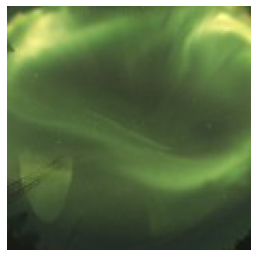

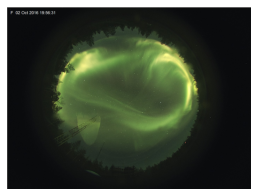

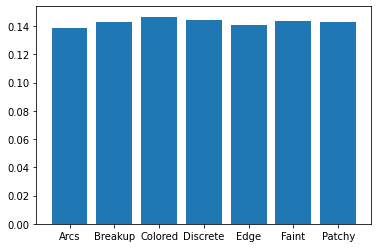

KeyboardInterrupt: ignored

In [42]:
for r_image in unlabelled_data:
  s_image = unlabelled_data[r_image]


  plot([r_image,s_image], scale=1.5)

  img_as_tensor = np.array(plt.imread(r_image)) / 255.
  img_as_tensor = torch.tensor(img_as_tensor)
  img_as_tensor = img_as_tensor.reshape(1,img_as_tensor.shape[0],img_as_tensor.shape[1],img_as_tensor.shape[2])
  img_as_tensor = tf.cast(img_as_tensor, tf.float32)

  #print(resnet_sd(img_as_tensor).numpy())
  plt.bar(classes[:-1], resnet_sd(img_as_tensor).numpy()[0])
  plt.show()

  label = input()
  output.clear()